## Выполнил Лялин И.Е. ББМО-02-24

# 1) Загрузить обученную модель и данные MNIST


In [7]:

import tensorflow as tf  # Основной фреймворк для работы с нейронными сетями
from tensorflow.keras.datasets import mnist  # Загрузка датасета MNIST
from tensorflow.keras.utils import to_categorical  # Утилита для преобразования меток в one-hot формат

(_, _), (test_images, test_labels) = mnist.load_data()  # Загружаем только тестовую выборку

test_images = test_images / 255.0  # Делим каждый пиксель на 255 для улучшения стабильности обучения и работы модели

test_labels = to_categorical(test_labels, num_classes=10)  # num_classes=10 указывает на 10 классов цифр

model = tf.keras.models.load_model('pr1_model.h5')  # Модель загружается вместе с архитектурой и весами

# Оценка точности модели на нормализованных тестовых данных
test_loss, test_acc = model.evaluate(test_images, test_labels)  # Метод evaluate возвращает loss и accuracy


print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9715 - loss: 0.0940
Test accuracy on clean images: 0.9760000109672546


# 2) Реализация атаки FGSM для генерации противоречивых примеров


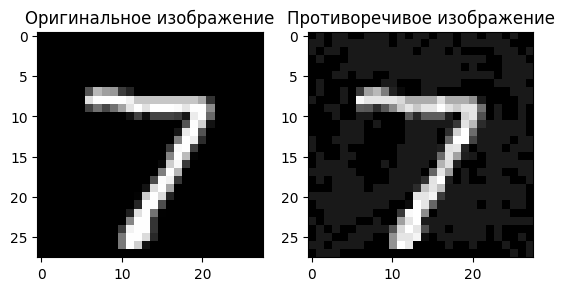

In [8]:
import numpy as np

# Функция для реализации FGSM атаки (Fast Gradient Sign Method)
def fgsm_attack(image, epsilon, gradient):

  # Создание противоречивого примера: добавляем к исходному изображению шум в направлении знака градиента
  perturbed_image = image + epsilon * np.sign(gradient)

  # Обеспечение корректного диапазона значений пикселей (между 0 и 1) после добавления шума
  perturbed_image = np.clip(perturbed_image, 0, 1)

  return perturbed_image

# Функция для генерации одного противоречивого примера
def generate_adversarial_example(model, image, label, epsilon):
    # Преобразование изображения в тензор TensorFlow и добавление размерностей батча и канала
    image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)))

    # Проверка формата метки: если one-hot, преобразуем в числовой формат
    if len(label.shape) > 1 and label.shape[1] > 1:
        label = np.argmax(label)
    # Преобразование метки в тензор TensorFlow
    label = tf.convert_to_tensor(label)

    # Использование GradientTape для автоматического вычисления градиентов
    with tf.GradientTape() as tape:
        # Отслеживание операций с входным изображением
        tape.watch(image)
        # Получение предсказания модели для текущего изображения
        prediction = model(image)
        # Вычисление значения функции потерь между предсказанием и истинной меткой
        loss = tf.keras.losses.categorical_crossentropy(label[None], prediction)

    # Вычисление градиента функции потерь по отношению к входному изображению
    gradient = tape.gradient(loss, image)

    # Применение FGSM-атаки к изображению с заданным коэффициентом epsilon
    adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())

    # Возвращение изображения в исходную форму (28, 28, 1) без размерности батча
    return np.reshape(adversarial_image, (28, 28, 1))

# Установка коэффициента мощности атаки (чем больше epsilon, тем сильнее искажения)
epsilon = 0.1  # Величина шума

# Генерация противоречивого примера для первого изображения из тестового набора
adversarial_example = generate_adversarial_example(model, test_images[0], test_labels[0], epsilon)

# Импорт библиотеки для визуализации результатов
import matplotlib.pyplot as plt


plt.figure()


plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(test_images[0], cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение")
# Преобразование формы изображения для отображения (убираем размерность канала)
plt.imshow(adversarial_example.reshape(28, 28), cmap="gray")

plt.show()

# 3)Оценка модели на противоречивых примерах


In [10]:
# Функция для генерации набора противоречивых примеров на основе всего датасета
def generate_adversarial_dataset(model, images, labels, epsilon):
    # Создание пустого списка для хранения противоречивых изображений
    adversarial_images = []

    # Итерация по всем изображениям в датасете
    for i in range(len(images)):
        # Генерация одного противоречивого примера для i-го изображения
        adv_image = generate_adversarial_example(model, images[i], labels[i], epsilon)
        # Изменение формы изображения (28, 28, 1) -> (28, 28) и добавление в список
        adversarial_images.append(adv_image.reshape(28, 28))

    # Преобразование списка в numpy array для удобства обработки
    adversarial_images = np.array(adversarial_images)

    # Вывод формы полученного массива для проверки корректности
    print("Shape of adversarial_images:", adversarial_images.shape)

    return adversarial_images

# Генерация набора противоречивых примеров для всего тестового датасета
adversarial_images = generate_adversarial_dataset(model, test_images, test_labels, epsilon)

# Оценка производительности модели на сгенерированных противоречивых примерах
# Метод evaluate возвращает значение функции потерь и точности
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)

# Вывод точности модели на противоречивых примерах
print(f'Accuracy on a small subset of adversarial examples: {adversarial_acc}')

Shape of adversarial_images: (10000, 28, 28)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0879 - loss: 6.8038
Accuracy on a small subset of adversarial examples: 0.11680000275373459


# Вывод: Точность на обычных примерах составляет 97,6%, на противоречивых — 11,68%. Из этого следует, что модель уязвима к атакующим примерам, она не справляется с задачей распознавания при небольших целенаправленных искажениях.